In [2]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colormaps


from astropy.io import fits
from IPython.display import HTML
from hcipy import *

from iefc_utils import *

import iefc_utils

import sys
import os
# sys.path.append('/home/jliberman/github_repos/magaox-iefc-sim/')
sys.path.append('/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/')
plt.style.use('spieposter')



In [3]:
# Set units

pupil_diameter = 6.5
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution


pupil_grid = make_pupil_grid(512, diameter=1.2*pupil_diameter)    # Pad the grid to offer a bit more room

focal_grid = make_focal_grid(q=5, num_airy=25, spatial_resolution = wavelength/pupil_diameter)

prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)

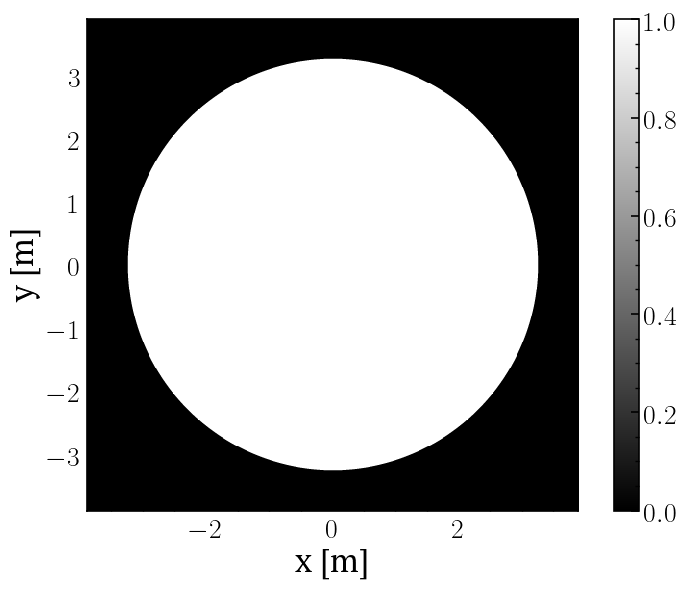

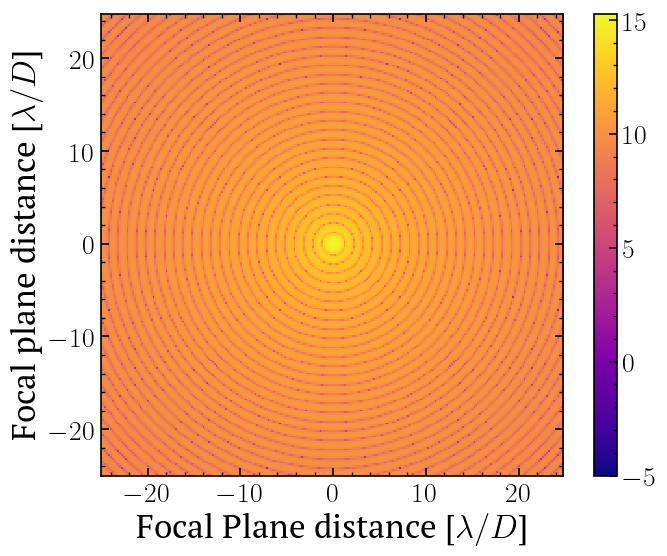

In [4]:
telescope_pupil_circ = evaluate_supersampled(make_circular_aperture(pupil_diameter), pupil_grid, 4)

# Plot telescope  pupil
imshow_field(telescope_pupil_circ, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.tight_layout()
# plt.savefig('../mag_ap.svg', transparent=True)
plt.show()

wavefront = Wavefront(telescope_pupil_circ, wavelength)

wavefront.total_power = 1

focal_image = prop.forward(wavefront)

norm = focal_image.power.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
# save_field('magellan_pup.svg', np.log10(focal_image.intensity / norm))
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()

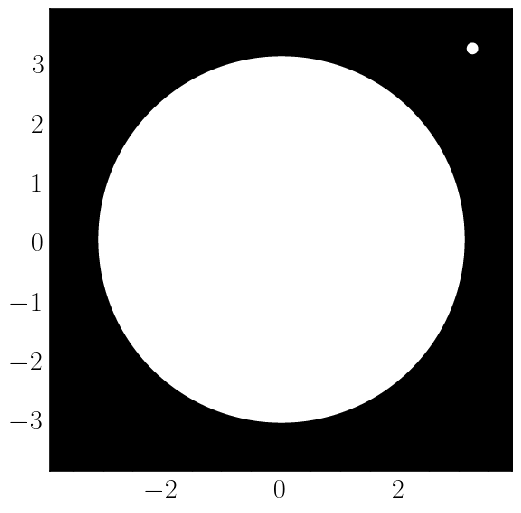

In [ ]:
# Generate slightly undersized Lyot Stop                   
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter), pupil_grid, 4)


# Add pinhole to Lyot mask 
# pinhole_pos = 0.8 * np.array([pupil_diameter/np.sqrt(2), pupil_diameter/np.sqrt(2)])
pinhole_pos = 0.7 * np.array([pupil_diameter/np.sqrt(2), pupil_diameter/np.sqrt(2)])

pinhole = evaluate_supersampled(make_circular_aperture(0.03*pupil_diameter, center=pinhole_pos), pupil_grid, 4)

scc_mask = lyot_mask + pinhole

# Plot SCC mask
imshow_field(scc_mask, cmap='gray')
plt.show()

scc_stop = Apodizer(scc_mask)

lyot_stop = Apodizer(lyot_mask)

pinhole_stop = Apodizer(pinhole)

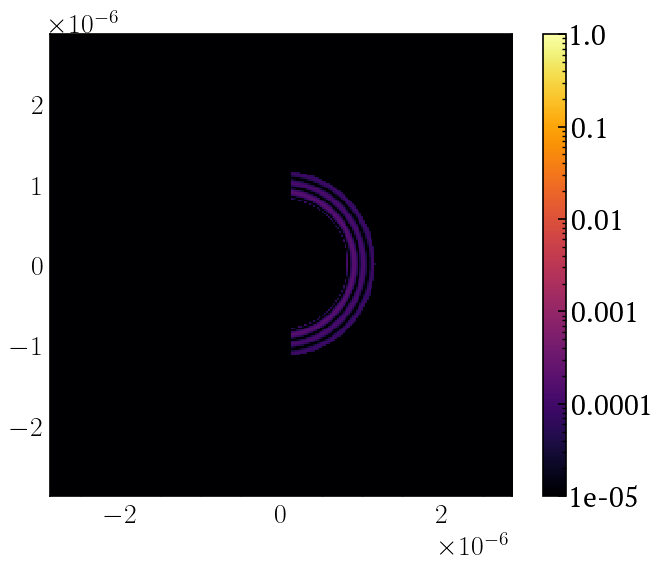

In [7]:


# Define control region

Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid


# fourier_mask = (fourier_grid.as_('polar').r < 10) * (fourier_grid.as_('polar').r > 2)   # Overlay modes from 2-10 lambda/d
# fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
# focal_mask *= focal_grid.x > 1*sr

wavefront_circ = Wavefront(telescope_pupil_circ, wavelength)

wavefront_circ.total_power = 1

# focal_image = prop.forward(wavefront)

 # fourier_mask = (fourier_grid.as_('polar').r < 14) * (fourier_grid.as_('polar').r > 6)   #  Overlay modes from 6-14 lambda/d


fourier_mask = (fourier_grid.as_('polar').r < 11) * (fourier_grid.as_('polar').r > 6)   
fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 13*sr) * (focal_grid.as_('polar').r > 7*sr) 


focal_mask = (focal_grid.as_('polar').r < 10*sr) * (focal_grid.as_('polar').r > 7*sr) 

focal_mask *= focal_grid.x > 1*sr

focal_image_circ = prop.forward(wavefront_circ)

dark_hole_pixels_circ = focal_image_circ.power*focal_mask



imshow_psf(dark_hole_pixels_circ/focal_image_circ.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     

fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region

fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region

In [8]:
############ Initialize VVC
charge = 4                      # Generate a charge 4 scalar CG
coro_vortex = VortexCoronagraph(pupil_grid, charge=charge)

In [9]:
# Initialize vars for Jacobian

optical_system_scc = OpticalSystem([scc_stop, prop])
optical_system_lyot = OpticalSystem([lyot_stop, prop])

wf_vortex = Wavefront(telescope_pupil_circ, wavelength)
wf_vortex.total_power = 1 # Always define power, normalize it to 1

sa = SurfaceAberration(pupil_grid, 0.1*wavelength, pupil_diameter)


/home/jasper/hcipy/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [10]:
response_matrices_selected = np.load('./jacobian_scc_circ_ap_7_10_new.npy')

reconstruction_matrices_selected = np.load('./rec_mat_scc_circ_ap_7_10_new.npy')

In [11]:
reconstruction_matrices_selected.shape

(272, 1854)

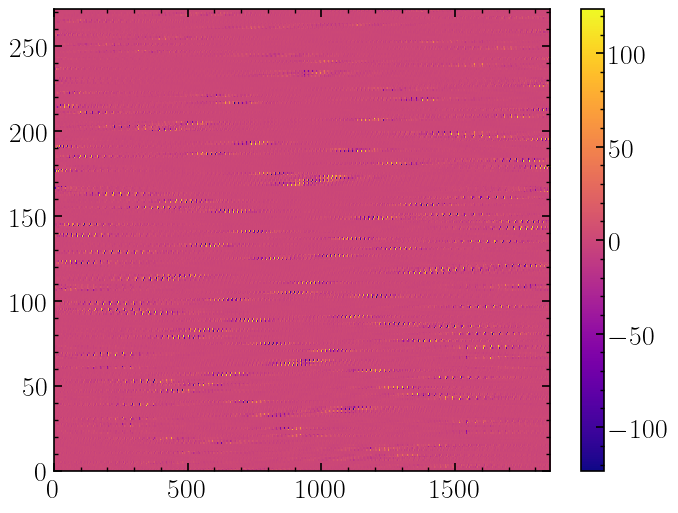

In [12]:
plt.imshow(response_matrices_selected,aspect='auto')
plt.colorbar()
plt.show()

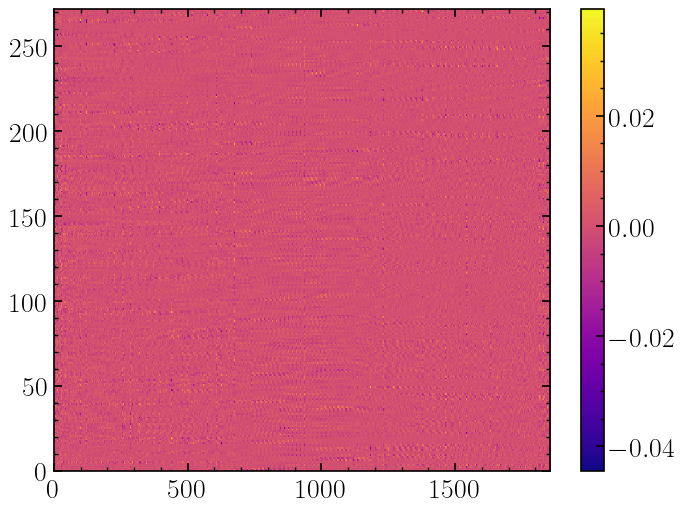

In [13]:
plt.imshow(reconstruction_matrices_selected,aspect='auto')
plt.colorbar()
plt.show()

In [14]:
def run_iefc(num_iterations=20, efc_gain=0.5, aberrations=0.1, dark_hole_pixels=dark_hole_pixels_circ, sa_optic=None, rec_mat_selected=reconstruction_matrices_selected):

    fourier_dm_selected.flatten()

    wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF

    wf.total_power = 1

    optical_system_scc = OpticalSystem([scc_stop, prop])
    optical_system_lyot = OpticalSystem([lyot_stop, prop])
    optical_system_pinhole = OpticalSystem([pinhole_stop, prop])

    norm = prop(wf).power.max()

    scc_sensor = make_scc_sensor(optical_system_scc, optical_system_lyot, optical_system_pinhole)

    if sa_optic is None:
        zmodes = make_zernike_basis(3, Dtel, pupil_grid)
        sa_optic = SurfaceAberration(pupil_grid, aberrations * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil_circ, remove_modes=zmodes)   # Apply 1/10 lambda of surface aberration

    actuator_cmds = np.zeros(fourier_dm_selected.num_actuators)

    current_cmds = []
    image_cube = []
    mean_ni = []

    image_cube.append(optical_system_scc(coro_vortex(fourier_dm_selected(sa_optic(wf)))).power / norm)

    # image_cube.append(optical_system_scc(wf_output).power / norm)
    for i in range(num_iterations):
        wf_output = coro_vortex(fourier_dm_selected(sa_optic(wf)))


        # print(wf_output)
        psf_scc, psf_lyot, psf_pinhole = scc_sensor(wf_output)  # Perform WFSing w/ SCC

        wf_measurement = extract_measurement_from_scc_image(psf_scc, psf_lyot, psf_pinhole, dark_hole_pixels>0) # Extract diff images

        ef_error = rec_mat_selected.dot(wf_measurement) # Transform WF sensing measurement into DM pattern that gives us error
        actuator_cmds -= efc_gain*ef_error # Apply opposite phase to DM so as to cancel E-field

        fourier_dm_selected.actuators = actuator_cmds
        
        print(actuator_cmds) # Check that actuator cmds are ~1e-9

        image_cube.append(optical_system_scc(coro_vortex(fourier_dm_selected(sa_optic(wf)))).power / norm)

    mean_ni = [np.mean(image[dark_hole_pixels>0]) for image in image_cube]

    image_cube_field = Field(image_cube, focal_grid)  
   
       # Uncomment if saving the individual images
    # write_field(image_cube_field, f'{PLOT_DIR}/Images/fpm_shift_{coro_str}_{tip_tilt}.fits')

    return image_cube_field, mean_ni  # TT.actuators


In [15]:
n_itrs = 40
img_cube, mean_ni = run_iefc(num_iterations=n_itrs, efc_gain=0.4, aberrations=0.1, dark_hole_pixels=dark_hole_pixels_circ, sa_optic=None, rec_mat_selected=reconstruction_matrices_selected) # Freeze sa such that soln. stays the same every ti

/home/jasper/hcipy/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


[ 2.91586253e-10 -3.50186235e-10 -9.16320712e-10  7.12932322e-10
 -5.57672888e-10 -5.64435682e-10  2.93424988e-10  2.95343461e-10
  5.06586777e-10  6.65780014e-10 -4.76032943e-12 -1.61259593e-10
 -8.71733604e-11 -2.58912738e-10  5.01735196e-10 -4.18463622e-10
 -4.18287222e-10 -6.87125463e-11 -1.40249165e-10  1.19111750e-10
  1.71720012e-10 -1.63557501e-10  1.67046481e-10 -2.84218067e-10
 -3.33073757e-10  7.10329022e-11 -6.04851480e-11  1.64611845e-10
 -4.00533247e-10  3.70459475e-10 -2.52983984e-10 -1.72132182e-10
 -1.38445958e-10 -1.99753492e-11 -2.75790837e-11  7.42721683e-12
 -4.42199387e-10 -2.84528656e-10  3.19977802e-10  4.28165278e-10
 -2.59192950e-10  2.82907798e-11  4.93504830e-10 -8.76650103e-10
 -4.12220029e-10 -1.28137696e-10  2.87456370e-10  1.25151753e-10
 -9.96287860e-11 -1.15240663e-10  1.85286190e-12 -7.08781696e-11
  1.88116767e-10 -9.08353400e-11 -3.51660668e-10  5.88023301e-10
  2.23013338e-10  1.25508904e-11  3.84112169e-10  1.88172327e-10
  6.64725819e-11 -9.43828

In [16]:
mean_ni = np.array(mean_ni) 

In [17]:
mean_ni

array([1.19638791e-05, 4.37801962e-06, 1.59476339e-06, 5.95035170e-07,
       2.41259488e-07, 1.17712392e-07, 7.52532774e-08, 6.10502592e-08,
       5.65713067e-08, 5.53765001e-08, 5.52558242e-08, 5.54682115e-08,
       5.57774274e-08, 5.61170031e-08, 5.64746789e-08, 5.68533081e-08,
       5.72582865e-08, 5.76940496e-08, 5.81635384e-08, 5.86685199e-08,
       5.92100566e-08, 5.97889133e-08, 6.04058559e-08, 6.10618543e-08,
       6.17582098e-08, 6.24966308e-08, 6.32792730e-08, 6.41087577e-08,
       6.49881778e-08, 6.59210961e-08, 6.69115417e-08, 6.79640044e-08,
       6.90834302e-08, 7.02752166e-08, 7.15452081e-08, 7.28996898e-08,
       7.43453791e-08, 7.58894134e-08, 7.75393305e-08, 7.93030412e-08,
       8.11887903e-08])

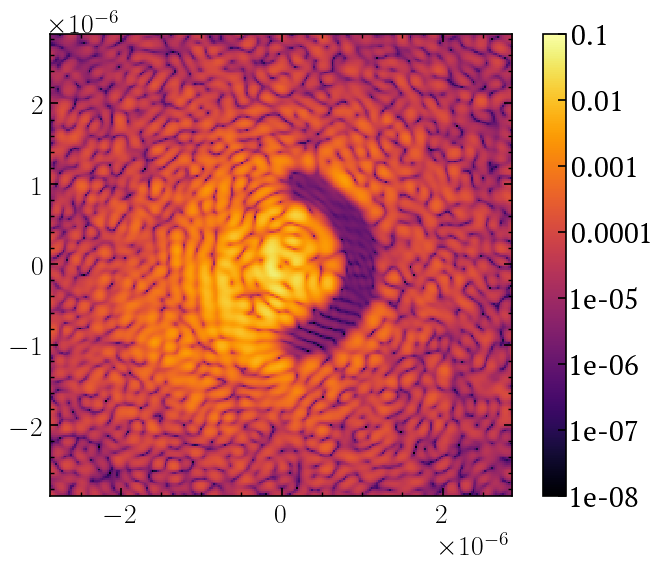

In [20]:
imshow_psf(img_cube[-1] / norm )